# MiniGrid settings

## Basic Jupyter Setting

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
#%load_ext autoreload
#%autoreload 2
%reload_ext autoreload
%autoreload 2

## Initial set-up

Import libraries and classes:

In [3]:
# Imports
import time
import io
import os
import glob
import torch
import base64
# import stable_baselines3

import numpy as np
import matplotlib.pyplot as plt
from random import randint 

import gym
from gym import spaces
from gym.wrappers import Monitor
import gym_minigrid
from gym_minigrid.wrappers import FlatObsWrapper, ImgObsWrapper, RGBImgPartialObsWrapper

Define the video function:

In [ ]:
import base64
import glob
import io
from IPython.display import HTML
from IPython import display 

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        
def show_animation(experiment):
    giflist = glob.glob('animation/*.gif')
    if len(giflist) > 0:
        matching = [s for s in giflist if experiment in s]
        gif_path = matching[0]
        b64 = base64.b64encode(open(gif_path,'rb').read()).decode('ascii')
        display.display(HTML(f'<img src="data:image/gif;base64,{b64}" height="400" />'))
    else:
        print("Could not find animation")

Define the rendering wrappers:

In [ ]:
from gym.wrappers import Monitor

# Define wrapper for CNN Policy
def ImgRGBImgPartialObsWrapper(env):
    return ImgObsWrapper(RGBImgPartialObsWrapper(env))

# Monitor is a gym wrapper, which helps easy rendering of videos of the wrapped environment.
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def gen_wrapped_env(env_name):
    return wrap_env(FlatObsWrapper(gym.make(env_name)))

def gen_wrapped_env_cnn(env_name):
    return wrap_env(ImgObsWrapper(RGBImgPartialObsWrapper(gym.make(env_name))))

Render an environment image:

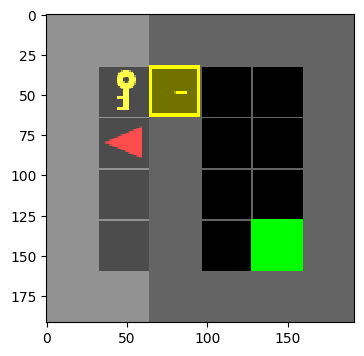

In [122]:
from random import randint
#env_id = 'MiniGrid-Empty-5x5-v0'
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-Empty-16x16-v0'
env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
#env_id = 'BreakoutNoFrameskip-v4'
#env_id = 'MiniGrid-DistShift1-v0'
#env_id ='MiniGrid-UnlockPickup-v0'
#env_id = 'MiniGrid-RedBlueDoors-6x6-v0'
#env_id = 'MiniGrid-LavaGapS6-v0'

eval_env = gym.make(env_id)
eval_env.seed(10000+randint(0, 10))
eval_env.reset()
#random_action = eval_env.action_space.sample()
#new_obs, reward, done, info = eval_env.step(random_action)

before_img = eval_env.render('rgb_array')

plt.figure(figsize = (4.,4.))
plt.imshow(before_img);

# Initial Meta-RIMs learning

## Define the environments

### Import libraries

In [4]:
import time
import datetime
import torch
import torch_ac
import tensorboardX
import sys

import utils
from model import ACModel
from torch_ac.utils import DictList, ParallelEnv

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

### Helper functions

In [5]:
def make_envs(env_id, procs, seed=None):
    envs = []
    for i in range(procs):
        if seed:
            e = utils.make_env(env_id, seed + 10000 * i)
        else:
            e = utils.make_env(env_id)
        envs.append(e)
    env = ParallelEnv(envs)
    return env

def sample_tasks(n_tasks):
    tasks_list = []
    for i in range(n_tasks):
        random_data = os.urandom(4)
        seed = int.from_bytes(random_data, byteorder="big")
        tasks_list.append(seed)
    return tasks_list

def env_snapshot(env:ParallelEnv):
    im_list = []
    for e in env.envs:
        #print(type(e.render('rgb_array')))
        #e.reset()
        im_list.append(e.render('rgb_array'))

    fig = plt.figure(figsize=(8., 8.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                    axes_pad=0.1,  # pad between axes in inch.
                    )

    for ax, im in zip(grid, im_list):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)

def set_freeze_status(model, params, freeze=True):
    for name, param in model.named_parameters():
        if any(ext in name for ext in params):
            param.requires_grad = False if freeze else True
            #param.grad = None if freeze else param.grad

# Function to concatenate two tasks rollout exps dictionaries
def cat_exps(exps_1, exps_2):
    exp_out = {}
    for (k,v), (k2,v2) in zip(exps_1.items(), exps_2.items()):
        if k == 'obs':
            obs = k
            exp_out[obs] = {}
            for (k,v), (k2,v2) in zip(exps_1.obs.items(), exps_2.obs.items()):
                exp_out[obs][k] = torch.cat((v, v2), 0)
        else:
            exp_out[k] = torch.cat((v, v2), 0)
    return exp_out

# Function to concatenate two tasks rollout logs dictionaries
def cat_logs(logs_1, logs_2):
    logs_out = {}
    for (k,v), (k2,v2) in zip(logs_1.items(), logs_2.items()):
        logs_out[k] = v + v2
    return logs_out

def change_multienv_seed(env, seed):
    for i, e in enumerate(env.envs):
        e.seed(seed + 10000 * i)
        e.reset()
    return env
        
def sample_tasks_experiences(agent, tasks):
    seed_list = tasks['seed_list']
    exps_batch = []
    logs1_batch = []
    for seed in seed_list:
        agent.env = change_multienv_seed(agent.env, seed)
        #agent.env = make_envs(env_id, procs, seed)
        exps, logs1 = agent.collect_experiences() 
        exps_batch.append(exps)
        logs1_batch.append(logs1)
    return exps_batch, logs1_batch

# Function to collect and concatenate all tasks rollout exps dictionaries
def collect_tasks_meta_experiences(agent, tasks):
    seed_list = tasks['seed_list']
    for i, seed in enumerate(seed_list):
        #agent.env = make_envs(env_id, procs, seed)
        agent.env = change_multienv_seed(agent.env, seed)
        exps, logs1 = agent.collect_experiences()
        concat_exps = exps if i==0 else cat_exps(concat_exps, exps)
        concat_exps = DictList(concat_exps)
        concat_exps.obs = DictList(concat_exps.obs)
        concat_logs1 = logs1 if i==0 else cat_logs(concat_logs1, logs1)
    return concat_exps, concat_logs1

### Render Parallel environment snapshot

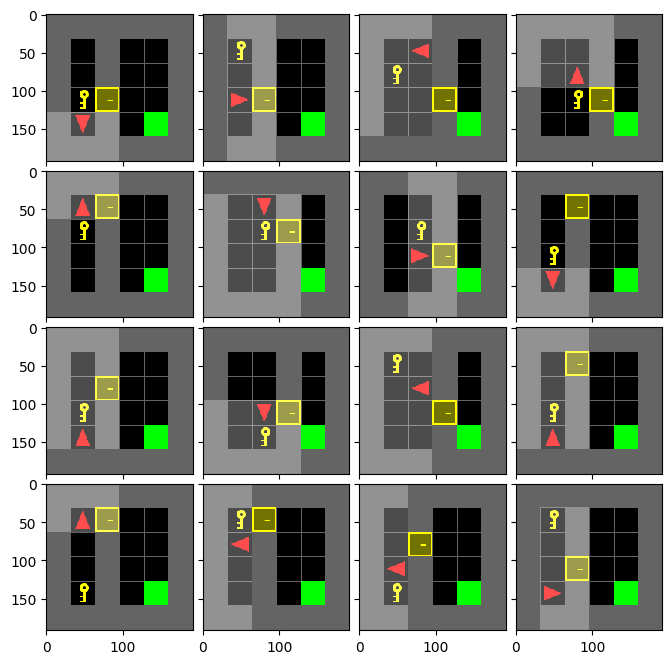

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

procs = 16
max_tasks = 20
seed_list = range(procs * max_tasks, (procs + 1) * max_tasks)

#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-5x5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
env_id = 'MiniGrid-DoorKey-6x6-v0'

seed = 5
env = make_envs(env_id, procs, seed)
obs = env.reset()

env_snapshot(env)

#plt.show()


## Configuration

### Load parameters

In [13]:
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-LavaGapS5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-WallGapS6-v0'
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-5x5-v0'
env_id = 'MiniGrid-SimpleCrossingS9N1-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N2-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N3-v0'
#env_id = 'MiniGrid-SimpleCrossingS11N5-v0'
#env_id = 'MiniGrid-LavaCrossingS9N2-v0'

model = 'MiniGrid-SimpleCrossingS9N1-v0_meta_RIM_5_3_frames_1M_tasks_2_recur_64_16_proc_16_RMSProp_lr_7e4_gae_099_test_MiniGrid-LavaCrossingS9N1-v0'

frames = 1e6

## Hyper-parameters
args = {
# General parameters
'algo':'ppo',
'env':env_id,
'model':model,
'seed':1,
'log_interval':1,
'save_interval':10,
'procs':16,
'frames':frames, # default 1e7
# Parameters for main algorithm
'epochs':4,
'batch_size':256,
'frames_per_proc':128, # 128 for PPO and 5 per A2C
'discount':0.99,
#'lr':0.0001, # for Adam
'lr':0.0007, # for RMSProp
#'gae_lambda':0.95, # 1 means no gae, for Adam
'gae_lambda':0.99, # 1 means no gae, for RMSProp
'entropy_coef':0.01,
'value_loss_coef':0.5,
'max_grad_norm':0.5,
'optim_eps':1e-8,
'optim_alpha':0.99,
'clip_eps':0.2,
'recurrence':32, # if > 1, a LSTM is added
'text':False, # add a GRU for text input
# Model Parameters
'use_rim':True # action = 'store_true'
}

#args = utils.dotdict(args)
args = DictList(args)

args.mem = args.recurrence > 1

# RIM specific hyperparameters
if args.use_rim:
    args.num_units = 5
    args.k = 3

### Initial settings

In [7]:
# Set run dir

date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S")
default_model_name = f"{args.env}_{args.algo}_seed{args.seed}_{date}"

model_name = args.model or default_model_name
model_dir = utils.get_model_dir(model_name)

# Load loggers and Tensorboard writer

txt_logger = utils.get_txt_logger(model_dir)
csv_file, csv_logger = utils.get_csv_logger(model_dir)
tb_writer = tensorboardX.SummaryWriter(model_dir)

# Log command and all script arguments

#txt_logger.info("{}\n".format(" ".join(sys.argv)))
txt_logger.info("{}\n".format(args))

# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
txt_logger.info(f"Device: {device}\n")

{'algo': 'ppo', 'env': 'MiniGrid-SimpleCrossingS9N1-v0', 'model': 'MiniGrid-SimpleCrossingS9N1-v0_meta_RIM_5_3_frames_1M_tasks_2_recur_64_16_proc_16_RMSProp_lr_7e4_gae_099_test_MiniGrid-LavaCrossingS9N1-v0', 'seed': 1, 'log_interval': 1, 'save_interval': 10, 'procs': 16, 'frames': 1000000.0, 'epochs': 4, 'batch_size': 256, 'frames_per_proc': 128, 'discount': 0.99, 'lr': 0.0007, 'gae_lambda': 0.99, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'optim_eps': 1e-08, 'optim_alpha': 0.99, 'clip_eps': 0.2, 'recurrence': 32, 'text': False, 'use_rim': True, 'mem': True, 'num_units': 5, 'k': 3}

Device: cpu



### Load environments, model, algo and prepare training settings

In [8]:
# Load environments

envs = []
for i in range(args.procs):
    envs.append(utils.make_env(args.env, args.seed + 10000 * i))
txt_logger.info("Environments loaded\n")

# Load training status

try:
    status = utils.get_status(model_dir)
except OSError:
    status = {"num_frames": 0, "update": 0}
txt_logger.info("Training status loaded\n")

# Load observations preprocessor

obs_space, preprocess_obss = utils.get_obss_preprocessor(envs[0].observation_space)
if "vocab" in status:
    preprocess_obss.vocab.load_vocab(status["vocab"])
txt_logger.info("Observations preprocessor loaded")

# Load model

acmodel = ACModel(obs_space, envs[0].action_space, args.mem, args.text, args.use_rim, args.num_units, args.k)
if "model_state" in status:
    acmodel.load_state_dict(status["model_state"])
acmodel.to(device)
txt_logger.info("Model loaded\n")
txt_logger.info("{}\n".format(acmodel))

# Load algo

if args.algo == "a2c":
    algo = torch_ac.A2CAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_alpha, args.optim_eps, preprocess_obss)
elif args.algo == "ppo":
    algo = torch_ac.PPOAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_eps, args.clip_eps, args.epochs, args.batch_size, preprocess_obss)
else:
    raise ValueError("Incorrect algorithm name: {}".format(args.algo))

# change to RMSProp optimizer
algo.optimizer = torch.optim.RMSprop(algo.acmodel.parameters(), args.lr, eps=args.optim_eps)

if "optimizer_state" in status:
    algo.optimizer.load_state_dict(status["optimizer_state"])
txt_logger.info("Optimizer loaded\n")

Environments loaded

Training status loaded

Observations preprocessor loaded
Model loaded

ACModel(
  (image_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (6): ReLU()
  )
  (memory_rnn): RIMCell(
    (key): Linear(in_features=64, out_features=64, bias=True)
    (value): Linear(in_features=64, out_features=64, bias=True)
    (rnn): GroupLSTMCell(
      (i2h): GroupLinearLayer()
      (h2h): GroupLinearLayer()
    )
    (query): GroupLinearLayer()
    (query_): GroupLinearLayer()
    (key_): GroupLinearLayer()
    (value_): GroupLinearLayer()
    (comm_attention_output): GroupLinearLayer()
    (comm_dropout): Dropout(p=0.1, inplace=False)
    (input_dropout): Dropout(p=0.1, inplace=False)
  )
  (actor): Sequentia

## Meta-training

### Set initial parameters

In [9]:
# meta-learn parameters
#lr_alpha = 0.0001 # inner loop lr - Adam
#lr_beta = 0.0001 # outer loop lr - Adam
lr_alpha = 0.0007 # RMSProp
lr_beta = 0.0007 # RMSProp
inner_recurrence = 16
outer_recurrence = 64 # 4x inner_recurrence
num_tasks = 2

inner_params = ['image_conv', 'i2h', 'h2h', 'actor'] # params to be updated in inner loop
outer_params = ['query', 'key', 'value', 'comm', 'critic'] # params to be updated in outer loop

# delete param_groups after it has been created
for i in range(len(algo.optimizer.param_groups)):
    del algo.optimizer.param_groups[0]

# Re-create separate param_groups for different inner and outer loop optimizer lr

# inner loop param group
algo.optimizer.add_param_group({'params': [
    *acmodel.image_conv.parameters(), 
    *acmodel.memory_rnn.rnn.parameters(), 
    *acmodel.actor.parameters()], 'lr': lr_alpha})

# outer loop param group
algo.optimizer.add_param_group({'params': [
    *acmodel.critic.parameters(), 
    *acmodel.memory_rnn.key.parameters(),
    *acmodel.memory_rnn.key_.parameters(),
    *acmodel.memory_rnn.query.parameters(),
    *acmodel.memory_rnn.query_.parameters(),
    *acmodel.memory_rnn.value.parameters(),
    *acmodel.memory_rnn.value_.parameters(),
    *acmodel.memory_rnn.comm_attention_output.parameters()
    ], 'lr': lr_beta})

### Old Training

In [ ]:
# run just once to have initial grads in all parameters and avoid backward error on first pass
exps, _ = algo.collect_experiences()
algo.update_parameters(exps)

while num_frames < args.frames: # STEP 2

    update_start_time = time.time()

    # # run just once to have initial grads in all parameters and avoid backward error on first pass
    # exps, _ = algo.collect_experiences()
    # algo.update_parameters(exps)

    # Sample batch of tasks: STEP 3
    tasks_batch = sample_tasks(n_tasks=num_tasks)

    # Sample pre-trajectories from each task: STEP 4
    exps_batch, logs1_batch = sample_tasks_experiences(agent=algo, tasks=tasks_batch)

    # Inner loop: STEPS 5-7

    # Unfreeze inner loop params so they can get updated in the inner loop
    set_freeze_status(algo.acmodel, inner_params, freeze=False)

    # Freeze outer loop parameters, so those grads will be zero in update
    set_freeze_status(algo.acmodel, outer_params, freeze=True)

    # set inner recurence
    algo.recurrence = inner_recurrence

    # Update parameters for all tasks 
    logs2_batch = []
    for exps in exps_batch: # STEP 5
        logs2 = algo.update_parameters(exps) # STEP 6
        logs2_batch.append(logs2)
    # STEP 7

    # Sample post-trajectories t_i from tasks T_i and concatenate to get D_meta: STEP 8
    meta_exps, meta_logs1 = collect_tasks_meta_experiences(agent=algo, tasks=tasks_batch)

    # Unfreeze outer loop params so they can get updated in the outer loop
    set_freeze_status(algo.acmodel, outer_params, freeze=False)
    # Freeze inner loop params 
    set_freeze_status(algo.acmodel, inner_params, freeze=True)

    # set outer recurence
    algo.recurrence = outer_recurrence

    # Update parameters while keeping inner parametes (module and policy) frozen: STEP 9
    meta_logs2 = algo.update_parameters(meta_exps)

    meta_logs = {**meta_logs1, **meta_logs2}
    update_end_time = time.time()

    num_frames += meta_logs["num_frames"]
    update += 1

    # Print logs

    if update % args.log_interval == 0:
        fps = meta_logs["num_frames"]/(update_end_time - update_start_time)
        duration = int(time.time() - start_time)
        return_per_episode = utils.synthesize(meta_logs["return_per_episode"])
        rreturn_per_episode = utils.synthesize(meta_logs["reshaped_return_per_episode"])
        num_frames_per_episode = utils.synthesize(meta_logs["num_frames_per_episode"])

        header = ["update", "frames", "FPS", "duration"]
        data = [update, num_frames, fps, duration]
        header += ["rreturn_" + key for key in rreturn_per_episode.keys()]
        data += rreturn_per_episode.values()
        header += ["num_frames_" + key for key in num_frames_per_episode.keys()]
        data += num_frames_per_episode.values()
        header += ["entropy", "value", "policy_loss", "value_loss", "grad_norm"]
        data += [meta_logs["entropy"], meta_logs["value"], meta_logs["policy_loss"], meta_logs["value_loss"], meta_logs["grad_norm"]]

        txt_logger.info(
            "U {} | F {:06} | FPS {:04.0f} | D {} | rR:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {} | H {:.3f} | V {:.3f} | pL {:.3f} | vL {:.3f} | ∇ {:.3f}"
            .format(*data))

        header += ["return_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()

        if status["num_frames"] == 0:
            csv_logger.writerow(header)
        csv_logger.writerow(data)
        csv_file.flush()

        for field, value in zip(header, data):
            tb_writer.add_scalar(field, value, num_frames)

    # Save status

    if args.save_interval > 0 and update % args.save_interval == 0:
        status = {"num_frames": num_frames, "update": update,
                  "model_state": acmodel.state_dict(), "optimizer_state": algo.optimizer.state_dict()}
        if hasattr(preprocess_obss, "vocab"):
            status["vocab"] = preprocess_obss.vocab.vocab
        utils.save_status(status, model_dir)
        txt_logger.info("Status saved")
# STEP 10

### Training

In [10]:
# Train model

num_frames = status["num_frames"]
update = status["update"]
start_time = time.time()

# Moving average parameters
threshold = 0.90
window = 5
rreturn_total = 0
i = 0
break_flag = False


# run just once to have initial grads in all parameters and avoid backward error on first pass
exps, _ = algo.collect_experiences()
algo.update_parameters(exps)

while num_frames < args.frames: # STEP 2

    update_start_time = time.time()

    # Sample batch of tasks: STEP 3
    tasks_batch = sample_tasks(n_tasks=num_tasks)

    for i, task in enumerate(tasks_batch):

        algo.env = change_multienv_seed(algo.env, seed=task)
        # Sample pre-trajectories from each task: STEP 4
        pre_exps, pre_logs1 = algo.collect_experiences()
         # Unfreeze inner loop params,so grads can get updated in the inner loop
        set_freeze_status(algo.acmodel, inner_params, freeze=False)
        # Freeze outer loop parameters, so grads do not get updated in the inner loop
        set_freeze_status(algo.acmodel, outer_params, freeze=True)
        # set inner RIM recurence
        algo.recurrence = inner_recurrence
        # Update parameters: STEP 6
        algo.update_parameters(pre_exps)
        # Sample post-trajectories t_i from tasks T_i: STEP 7
        post_exps, post_logs1 = algo.collect_experiences()
        # Concatenate to get D_meta: STEP 8
        meta_exps = post_exps if i==0 else cat_exps(meta_exps, post_exps)
        meta_exps = DictList(meta_exps)
        meta_exps.obs = DictList(meta_exps.obs)
        meta_logs1 = post_logs1 if i==0 else cat_logs(meta_logs1, post_logs1)

    # Unfreeze outer loop params, so so grads can get updated in the outer loop
    set_freeze_status(algo.acmodel, outer_params, freeze=False)
    # Freeze inner loop params, so grads do not get updated in the outer loop
    set_freeze_status(algo.acmodel, inner_params, freeze=True)   
    
    # set outer RIM recurence
    algo.recurrence = outer_recurrence

    # Update parameters while keeping inner parametes (module and policy) frozen: STEP 9
    meta_logs2 = algo.update_parameters(meta_exps)

    meta_logs = {**meta_logs1, **meta_logs2}
    update_end_time = time.time()

    num_frames += meta_logs["num_frames"]
    update += 1    
    
    # Print logs

    if update % args.log_interval == 0:
        fps = meta_logs["num_frames"]/(update_end_time - update_start_time)
        duration = int(time.time() - start_time)
        return_per_episode = utils.synthesize(meta_logs["return_per_episode"])
        rreturn_per_episode = utils.synthesize(meta_logs["reshaped_return_per_episode"])
        num_frames_per_episode = utils.synthesize(meta_logs["num_frames_per_episode"])
        # Moving average to break loop if mean reward threshold reached
        rreturn_total +=rreturn_per_episode['mean']
        i+=1
        if i >= window:
            rreturn_mavg = rreturn_total / i
            if rreturn_mavg >= threshold:
                break_flag = True 
                break
            else:
                i = 0
                rreturn_total = 0
        if break_flag: break

        header = ["update", "frames", "FPS", "duration"]
        data = [update, num_frames, fps, duration]
        header += ["rreturn_" + key for key in rreturn_per_episode.keys()]
        data += rreturn_per_episode.values()
        header += ["num_frames_" + key for key in num_frames_per_episode.keys()]
        data += num_frames_per_episode.values()
        header += ["entropy", "value", "policy_loss", "value_loss", "grad_norm"]
        data += [meta_logs["entropy"], meta_logs["value"], meta_logs["policy_loss"], meta_logs["value_loss"], meta_logs["grad_norm"]]

        txt_logger.info(
            "U {} | F {:06} | FPS {:04.0f} | D {} | rR:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {} | H {:.3f} | V {:.3f} | pL {:.3f} | vL {:.3f} | ∇ {:.3f}"
            .format(*data))

        header += ["return_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()

        if status["num_frames"] == 0:
            csv_logger.writerow(header)
        csv_logger.writerow(data)
        csv_file.flush()

        for field, value in zip(header, data):
            tb_writer.add_scalar(field, value, num_frames)

    # Save status

    if args.save_interval > 0 and update % args.save_interval == 0:
        status = {"num_frames": num_frames, "update": update,
                  "model_state": acmodel.state_dict(), "optimizer_state": algo.optimizer.state_dict()}
        if hasattr(preprocess_obss, "vocab"):
            status["vocab"] = preprocess_obss.vocab.vocab
        utils.save_status(status, model_dir)
        txt_logger.info("Status saved")
# STEP 10

print("Number of frames: ", num_frames)

U 1 | F 004096 | FPS 0332 | D 17 | rR:μσmM 0.03 0.10 0.00 0.38 | F:μσmM 306.3 60.0 0.0 324.0 | H 1.944 | V 0.006 | pL 0.009 | vL 0.000 | ∇ 0.001
U 2 | F 008192 | FPS 0333 | D 29 | rR:μσmM 0.01 0.05 0.00 0.28 | F:μσmM 322.0 11.0 261.0 324.0 | H 1.946 | V 0.002 | pL 0.001 | vL 0.000 | ∇ 0.001
U 3 | F 012288 | FPS 0317 | D 42 | rR:μσmM 0.01 0.05 0.00 0.27 | F:μσmM 322.1 10.4 264.0 324.0 | H 1.945 | V 0.006 | pL 0.002 | vL 0.000 | ∇ 0.006
U 4 | F 016384 | FPS 0324 | D 54 | rR:μσmM 0.03 0.11 0.00 0.52 | F:μσmM 316.1 31.3 174.0 324.0 | H 1.945 | V 0.003 | pL 0.001 | vL 0.000 | ∇ 0.004
U 5 | F 020480 | FPS 0278 | D 69 | rR:μσmM 0.06 0.16 0.00 0.55 | F:μσmM 308.6 46.0 162.0 324.0 | H 1.945 | V 0.010 | pL -0.009 | vL 0.002 | ∇ 0.023
U 6 | F 024576 | FPS 0185 | D 91 | rR:μσmM 0.02 0.08 0.00 0.41 | F:μσmM 318.5 20.4 214.0 324.0 | H 1.945 | V 0.008 | pL 0.001 | vL 0.001 | ∇ 0.012
U 7 | F 028672 | FPS 0272 | D 106 | rR:μσmM 0.03 0.14 0.00 0.70 | F:μσmM 313.8 41.8 107.0 324.0 | H 1.946 | V 0.003 | p

## Evaluation

### Load parameters

In [14]:
from torch_ac.utils.penv import ParallelEnv

#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-WallGapS6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
env_id = 'MiniGrid-SimpleCrossingS9N1-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N2-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N3-v0'
#env_id = 'MiniGrid-SimpleCrossingS11N5-v0'
#env_id = 'MiniGrid-LavaCrossingS9N2-v0'

args.env = env_id

## Hyper-parameters
args = {
# General parameters
'env':args.env,
'model':model,
'episodes':100,
'seed':2,
'procs':16,
'argmax':False,
'worst_episodes_to_show':10,
'mem':args.mem,
'use_rim':args.use_rim,
'num_units':args.num_units,
'k':args.k
#'num_units':4,
#'k':2
}

args = DictList(args)
print(args)

# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

{'env': 'MiniGrid-SimpleCrossingS9N1-v0', 'model': 'MiniGrid-SimpleCrossingS9N1-v0_meta_RIM_5_3_frames_1M_tasks_2_recur_64_16_proc_16_RMSProp_lr_7e4_gae_099_test_MiniGrid-LavaCrossingS9N1-v0', 'episodes': 100, 'seed': 2, 'procs': 16, 'argmax': False, 'worst_episodes_to_show': 10, 'mem': True, 'use_rim': True, 'num_units': 5, 'k': 3}
Device: cpu



### Set environments, agent and logs

In [15]:
# Load environments

envs = []
for i in range(args.procs):
    env = utils.make_env(args.env, args.seed + 10000 * i)
    envs.append(env)
env = ParallelEnv(envs)
print("Environments loaded\n")

# Load agent

model_dir = utils.get_model_dir(args.model)
agent = utils.Agent(obs_space=env.observation_space, action_space=env.action_space, model_dir=model_dir, device=device, argmax=args.argmax, num_envs=args.procs, use_memory=args.mem, use_text=False,use_rim=args.use_rim, num_units=args.num_units, k=args.k)
print("Agent loaded\n")

# Initialize logs

logs = {"num_frames_per_episode": [], "return_per_episode": []}

Environments loaded

Agent loaded



### Run agent

In [16]:
# Run agent

start_time = time.time()

obss = env.reset()

log_done_counter = 0
log_episode_return = torch.zeros(args.procs, device=device)
log_episode_num_frames = torch.zeros(args.procs, device=device)

while log_done_counter < args.episodes:
    actions = agent.get_actions(obss)
    obss, rewards, dones, _ = env.step(actions)
    agent.analyze_feedbacks(rewards, dones)

    log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
    log_episode_num_frames += torch.ones(args.procs, device=device)

    for i, done in enumerate(dones):
        if done:
            log_done_counter += 1
            logs["return_per_episode"].append(log_episode_return[i].item())
            logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

    mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
    log_episode_return *= mask
    log_episode_num_frames *= mask

end_time = time.time()
print("Agent run completed\n")

Agent run completed



### Print logs and results

In [17]:
# Print logs

num_frames = sum(logs["num_frames_per_episode"])
fps = num_frames/(end_time - start_time)
duration = int(end_time - start_time)
return_per_episode = utils.synthesize(logs["return_per_episode"])
num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(num_frames, fps, duration,
              *return_per_episode.values(),
              *num_frames_per_episode.values()))

# Print worst episodes

n = args.worst_episodes_to_show
if n > 0:
    print("\n{} worst episodes:".format(n))

    indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
    for i in indexes[:n]:
        print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))

F 2833.0 | FPS 3091 | D 0 | R:μσmM 0.92 0.03 0.77 0.96 | F:μσmM 28.3 9.4 16.0 82.0

10 worst episodes:
- episode 36: R=0.7722222208976746, F=82.0
- episode 25: R=0.8222222328186035, F=64.0
- episode 93: R=0.855555534362793, F=52.0
- episode 16: R=0.8583333492279053, F=51.0
- episode 14: R=0.8666666746139526, F=48.0
- episode 90: R=0.875, F=45.0
- episode 12: R=0.8777777552604675, F=44.0
- episode 95: R=0.8833333253860474, F=42.0
- episode 84: R=0.8861111402511597, F=41.0
- episode 72: R=0.8888888955116272, F=40.0


## Visualization

### Load parameters

In [ ]:
import array2gif
from pathlib import Path
import numpy

## Hyper-parameters
args = {
# General parameters
'env':args.env,
'model':args.model,
'seed':15,
'shift':0,
'argmax':False,
'pause':0.1,
'gif':args.model,
'episodes':5,
# Model Parameters
'use_rim':args.use_rim,
'num_units':args.num_units,
'k':args.k
}

args = DictList(args)
print(args)

### Set environment, agent and logs

In [ ]:
# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

# Load environment

env = utils.make_env(args.env, args.seed)
for _ in range(args.shift):
    env.reset()
print("Environment loaded\n")

# Load agent

model_dir = utils.get_model_dir(args.model)
agent = utils.Agent(env.observation_space, env.action_space, model_dir, device, args.argmax, use_rim = args.use_rim, num_units = args.num_units, k = args.k)

print("Agent loaded\n")

### Make animation

In [ ]:
%%capture
# Run the agent

if args.gif:
   from array2gif import write_gif
   frames = []

# Create a window to view the environment
env.render('human')

for episode in range(args.episodes):
    obs = env.reset()
    done2 = False
    while True:
        env.render('human')
        if args.gif:
            frames.append(numpy.moveaxis(env.render("rgb_array"), 2, 0))
            

        action = agent.get_action(obs)
        obs, reward, done, _ = env.step(action)
        agent.analyze_feedback(reward, done)
        
        if done or env.window.closed:
            if episode == 4:
                done2 = True
            break
    if done2 == True:
        env.close()
        break
    #if env.window.closed:
    #    break
print('doneeee')
if args.gif:
    print("Saving gif... ", end="")
    utils.create_folders_if_necessary("./animation")
    #Path("./animation").mkdir(parents=True, exist_ok=True)
    write_gif(numpy.array(frames), "./animation/"+args.gif+".gif")
    print("Done.")

In [ ]:
show_animation(args.model)

### Make video

In [ ]:
test_env = wrap_env(env)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
    action = agent.get_action(observation)
    observation, reward, done, info = test_env.step(action)
    episode_reward += reward
    episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

# Continue meta-RIMs learning on 2nd environment

## Configuration

### Set general parameters

In [26]:
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-WallGapS6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N1-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N2-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N3-v0'
#env_id = 'MiniGrid-SimpleCrossingS11N5-v0'
env_id = 'MiniGrid-LavaCrossingS9N1-v0'
add_frames = 2.5e6
frames = frames + add_frames

## Hyper-parameters
args = {
# General parameters
'algo':'ppo',
'env':env_id,
'model':model,
'seed':1,
'log_interval':1,
'save_interval':10,
'procs':16,
'frames':frames, # default 1e7
# Parameters for main algorithm
'epochs':4,
'batch_size':256,
'frames_per_proc':128, # 128 for PPO and 5 per A2C
'discount':0.99,
#'lr':0.0001, # for Adam
'lr':0.0007, # for RMSProp
#'gae_lambda':0.95, # 1 means no gae, for Adam
'gae_lambda':0.99, # 1 means no gae, for RMSProp
'entropy_coef':0.01,
'value_loss_coef':0.5,
'max_grad_norm':0.5,
'optim_eps':1e-8,
'optim_alpha':0.99,
'clip_eps':0.2,
'recurrence':32, # if > 1, a LSTM is added
'text':False, # add a GRU for text input
# Model Parameters
'use_rim':True # action = 'store_true'
}

#args = utils.dotdict(args)
args = DictList(args)

args.mem = args.recurrence > 1

# RIM specific hyperparameters
if args.use_rim:
    args.num_units = 5
    args.k = 3

# meta-learn parameters
#lr_alpha = 0.0001 # inner loop lr - Adam
#lr_beta = 0.0001 # outer loop lr - Adam
lr_alpha = 0.0007 # RMSProp
lr_beta = 0.0007 # RMSProp
inner_recurrence = 16
outer_recurrence = 64 # 4x inner_recurrence
num_tasks = 2

### Load previous loggers and settings

In [19]:
date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S")
default_model_name = f"{args.env}_{args.algo}_seed{args.seed}_{date}"

model_name = args.model or default_model_name
model_dir = utils.get_model_dir(model_name)

# Load loggers and Tensorboard writer

txt_logger = utils.get_txt_logger(model_dir)
csv_file, csv_logger = utils.get_csv_logger(model_dir)
tb_writer = tensorboardX.SummaryWriter(model_dir)

# Log command and all script arguments

#txt_logger.info("{}\n".format(" ".join(sys.argv)))
txt_logger.info("{}\n".format(args))

# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
txt_logger.info(f"Device: {device}\n")

{'algo': 'ppo', 'env': 'MiniGrid-LavaCrossingS9N1-v0', 'model': 'MiniGrid-SimpleCrossingS9N1-v0_meta_RIM_5_3_frames_1M_tasks_2_recur_64_16_proc_16_RMSProp_lr_7e4_gae_099_test_MiniGrid-LavaCrossingS9N1-v0', 'seed': 1, 'log_interval': 1, 'save_interval': 10, 'procs': 16, 'frames': 3500000.0, 'epochs': 4, 'batch_size': 256, 'frames_per_proc': 128, 'discount': 0.99, 'lr': 0.0007, 'gae_lambda': 0.99, 'entropy_coef': 0.01, 'value_loss_coef': 0.5, 'max_grad_norm': 0.5, 'optim_eps': 1e-08, 'optim_alpha': 0.99, 'clip_eps': 0.2, 'recurrence': 32, 'text': False, 'use_rim': True, 'mem': True, 'num_units': 5, 'k': 3}

Device: cpu



### Load existing environments, model and training status (TEST for CF)

In [20]:
# Load environments

envs = []
for i in range(args.procs):
    envs.append(utils.make_env(args.env, args.seed + 10000 * i))
txt_logger.info("Environments loaded\n")

envs = make_envs(args.env, args.procs, args.seed)

algo.env = envs

Environments loaded



### Load existing environments, model and training status

In [23]:
# Load environments

envs = []
for i in range(args.procs):
    envs.append(utils.make_env(args.env, args.seed + 10000 * i))
txt_logger.info("Environments loaded\n")

# Load training status

try:
    status = utils.get_status(model_dir)
except OSError:
    status = {"num_frames": 0, "update": 0}
txt_logger.info("Training status loaded\n")

# Load observations preprocessor

obs_space, preprocess_obss = utils.get_obss_preprocessor(envs[0].observation_space)
if "vocab" in status:
    preprocess_obss.vocab.load_vocab(status["vocab"])
txt_logger.info("Observations preprocessor loaded")

# Load model

acmodel = ACModel(obs_space, envs[0].action_space, args.mem, args.text, args.use_rim, args.num_units, args.k)
if "model_state" in status:
    acmodel.load_state_dict(status["model_state"])
acmodel.to(device)
txt_logger.info("Model loaded\n")
txt_logger.info("{}\n".format(acmodel))

# Load algo

if args.algo == "a2c":
    algo = torch_ac.A2CAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_alpha, args.optim_eps, preprocess_obss)
elif args.algo == "ppo":
    algo = torch_ac.PPOAlgo(envs, acmodel, device, args.frames_per_proc, args.discount, args.lr, args.gae_lambda,
                            args.entropy_coef, args.value_loss_coef, args.max_grad_norm, args.recurrence,
                            args.optim_eps, args.clip_eps, args.epochs, args.batch_size, preprocess_obss)
else:
    raise ValueError("Incorrect algorithm name: {}".format(args.algo))

# change to RMSProp optimizer
algo.optimizer = torch.optim.RMSprop(algo.acmodel.parameters(), args.lr, eps=args.optim_eps)

# delete param_groups after it has been created
for i in range(len(algo.optimizer.param_groups)):
    del algo.optimizer.param_groups[0]

# Re-create separate param_groups for different inner and outer loop optimizer lr

# inner loop param group
algo.optimizer.add_param_group({'params': [
    *acmodel.image_conv.parameters(), 
    *acmodel.memory_rnn.rnn.parameters(), 
    *acmodel.actor.parameters()], 'lr': lr_alpha})

# outer loop param group
algo.optimizer.add_param_group({'params': [
    *acmodel.critic.parameters(), 
    *acmodel.memory_rnn.key.parameters(),
    *acmodel.memory_rnn.key_.parameters(),
    *acmodel.memory_rnn.query.parameters(),
    *acmodel.memory_rnn.query_.parameters(),
    *acmodel.memory_rnn.value.parameters(),
    *acmodel.memory_rnn.value_.parameters(),
    *acmodel.memory_rnn.comm_attention_output.parameters()
    ], 'lr': lr_beta})

if "optimizer_state" in status:
    algo.optimizer.load_state_dict(status["optimizer_state"])
txt_logger.info("Optimizer loaded\n")

Environments loaded

Training status loaded

Observations preprocessor loaded
Model loaded

ACModel(
  (image_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (6): ReLU()
  )
  (memory_rnn): RIMCell(
    (key): Linear(in_features=64, out_features=64, bias=True)
    (value): Linear(in_features=64, out_features=64, bias=True)
    (rnn): GroupLSTMCell(
      (i2h): GroupLinearLayer()
      (h2h): GroupLinearLayer()
    )
    (query): GroupLinearLayer()
    (query_): GroupLinearLayer()
    (key_): GroupLinearLayer()
    (value_): GroupLinearLayer()
    (comm_attention_output): GroupLinearLayer()
    (comm_dropout): Dropout(p=0.1, inplace=False)
    (input_dropout): Dropout(p=0.1, inplace=False)
  )
  (actor): Sequentia

## Continue training

In [24]:
# Training loop

num_frames = status["num_frames"]
update = status["update"]
start_time = time.time()

# Moving average parameters
threshold = 0.90
window = 5
rreturn_total = 0
i = 0
break_flag = False

# run just once to have initial grads in all parameters and avoid backward error on first pass
# exps, _ = algo.collect_experiences()
# algo.update_parameters(exps)

while num_frames < args.frames: # STEP 2

    update_start_time = time.time()

    # # run just once to have initial grads in all parameters and avoid backward error on first pass
    # exps, _ = algo.collect_experiences()
    # algo.update_parameters(exps)

    # Sample batch of tasks: STEP 3
    tasks_batch = sample_tasks(n_tasks=num_tasks)

    for i, task in enumerate(tasks_batch):

        algo.env = change_multienv_seed(algo.env, seed=task)
        #algo.env = make_envs(args.env, args.procs, seed=task)
        # Sample pre-trajectories from each task: STEP 4
        pre_exps, pre_logs1 = algo.collect_experiences()
         # Unfreeze inner loop params so they can get updated in the inner loop
        set_freeze_status(algo.acmodel, inner_params, freeze=False)
        # Freeze outer loop parameters, so those grads will be zero in update
        set_freeze_status(algo.acmodel, outer_params, freeze=True)
        # set inner recurence
        algo.recurrence = inner_recurrence
        # Update parameters: STEP 6
        algo.update_parameters(pre_exps)
        # Sample post-trajectories t_i from tasks T_i: STEP 7
        post_exps, post_logs1 = algo.collect_experiences()
        # Concatenate to get D_meta: STEP 8
        meta_exps = post_exps if i==0 else cat_exps(meta_exps, post_exps)
        meta_exps = DictList(meta_exps)
        meta_exps.obs = DictList(meta_exps.obs)
        meta_logs1 = post_logs1 if i==0 else cat_logs(meta_logs1, post_logs1)

    # Unfreeze outer loop params so they can get updated in the outer loop
    set_freeze_status(algo.acmodel, outer_params, freeze=False)
    # Freeze inner loop params 
    set_freeze_status(algo.acmodel, inner_params, freeze=True)   
    
    # set outer recurence
    algo.recurrence = outer_recurrence

    # Update parameters while keeping inner parametes (module and policy) frozen: STEP 9
    meta_logs2 = algo.update_parameters(meta_exps)

    meta_logs = {**meta_logs1, **meta_logs2}
    update_end_time = time.time()

    num_frames += meta_logs["num_frames"]
    update += 1    
    
    # Print logs

    if update % args.log_interval == 0:
        fps = meta_logs["num_frames"]/(update_end_time - update_start_time)
        duration = int(time.time() - start_time)
        return_per_episode = utils.synthesize(meta_logs["return_per_episode"])
        rreturn_per_episode = utils.synthesize(meta_logs["reshaped_return_per_episode"])
        num_frames_per_episode = utils.synthesize(meta_logs["num_frames_per_episode"])
        # Moving average to break loop if mean reward threshold reached
        rreturn_total +=rreturn_per_episode['mean']
        i+=1
        if i >= window:
            rreturn_mavg = rreturn_total / i
            if rreturn_mavg >= threshold:
                break_flag = True 
                break
            else:
                i = 0
                rreturn_total = 0
        if break_flag: break

        header = ["update", "frames", "FPS", "duration"]
        data = [update, num_frames, fps, duration]
        header += ["rreturn_" + key for key in rreturn_per_episode.keys()]
        data += rreturn_per_episode.values()
        header += ["num_frames_" + key for key in num_frames_per_episode.keys()]
        data += num_frames_per_episode.values()
        header += ["entropy", "value", "policy_loss", "value_loss", "grad_norm"]
        data += [meta_logs["entropy"], meta_logs["value"], meta_logs["policy_loss"], meta_logs["value_loss"], meta_logs["grad_norm"]]

        txt_logger.info(
            "U {} | F {:06} | FPS {:04.0f} | D {} | rR:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {} | H {:.3f} | V {:.3f} | pL {:.3f} | vL {:.3f} | ∇ {:.3f}"
            .format(*data))

        header += ["return_" + key for key in return_per_episode.keys()]
        data += return_per_episode.values()

        if status["num_frames"] == 0:
            csv_logger.writerow(header)
        csv_logger.writerow(data)
        csv_file.flush()

        for field, value in zip(header, data):
            tb_writer.add_scalar(field, value, num_frames)

    # Save status

    if args.save_interval > 0 and update % args.save_interval == 0:
        status = {"num_frames": num_frames, "update": update,
                  "model_state": acmodel.state_dict(), "optimizer_state": algo.optimizer.state_dict()}
        if hasattr(preprocess_obss, "vocab"):
            status["vocab"] = preprocess_obss.vocab.vocab
        utils.save_status(status, model_dir)
        txt_logger.info("Status saved")
# STEP 10

print("Number of frames: ", num_frames)

U 851 | F 3485696 | FPS 0325 | D 12 | rR:μσmM 0.69 0.28 0.00 0.96 | F:μσmM 89.4 76.4 10.0 324.0 | H 1.762 | V 0.375 | pL 0.043 | vL 0.020 | ∇ 0.093
U 852 | F 3489792 | FPS 0323 | D 25 | rR:μσmM 0.63 0.31 0.00 0.93 | F:μσmM 84.5 50.8 21.0 282.0 | H 1.747 | V 0.428 | pL -0.023 | vL 0.030 | ∇ 0.058
U 853 | F 3493888 | FPS 0329 | D 37 | rR:μσmM 0.76 0.19 0.00 0.93 | F:μσmM 74.9 43.5 24.0 216.0 | H 1.686 | V 0.480 | pL -0.025 | vL 0.026 | ∇ 0.076
U 854 | F 3497984 | FPS 0328 | D 50 | rR:μσmM 0.74 0.21 0.00 0.94 | F:μσmM 78.5 47.8 23.0 219.0 | H 1.716 | V 0.429 | pL 0.053 | vL 0.023 | ∇ 0.168
U 855 | F 3502080 | FPS 0324 | D 62 | rR:μσmM 0.72 0.28 0.00 0.93 | F:μσmM 78.5 56.9 16.0 324.0 | H 1.731 | V 0.375 | pL 0.032 | vL 0.021 | ∇ 0.114
U 856 | F 3506176 | FPS 0325 | D 75 | rR:μσmM 0.71 0.25 0.00 0.93 | F:μσmM 80.0 53.3 6.0 215.0 | H 1.684 | V 0.436 | pL -0.038 | vL 0.024 | ∇ 0.100
U 857 | F 3510272 | FPS 0326 | D 88 | rR:μσmM 0.78 0.19 0.00 0.93 | F:μσmM 66.1 45.2 21.0 271.0 | H 1.666 | V 

## Evaluate 2nd environment

### Load parameters

In [27]:
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-WallGapS6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N1-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N2-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N3-v0'
#env_id = 'MiniGrid-SimpleCrossingS11N5-v0'
env_id = 'MiniGrid-LavaCrossingS9N1-v0'

args.env = env_id

## Hyper-parameters
args = {
# General parameters
'env':args.env,
'model':model,
'episodes':100,
'seed':2,
'procs':16,
'argmax':False,
'worst_episodes_to_show':10,
'mem':args.mem,
'use_rim':args.use_rim,
'num_units':args.num_units,
'k':args.k
}

args = DictList(args)
print(args)

# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

{'env': 'MiniGrid-LavaCrossingS9N1-v0', 'model': 'MiniGrid-SimpleCrossingS9N1-v0_meta_RIM_5_3_frames_1M_tasks_2_recur_64_16_proc_16_RMSProp_lr_7e4_gae_099_test_MiniGrid-LavaCrossingS9N1-v0', 'episodes': 100, 'seed': 2, 'procs': 16, 'argmax': False, 'worst_episodes_to_show': 10, 'mem': True, 'use_rim': True, 'num_units': 5, 'k': 3}
Device: cpu



### Set environments, agent and logs

In [28]:
# Load environments

envs = []
for i in range(args.procs):
    env = utils.make_env(args.env, args.seed + 10000 * i)
    envs.append(env)
env = ParallelEnv(envs)
print("Environments loaded\n")

# Load agent

model_dir = utils.get_model_dir(args.model)
agent = utils.Agent(obs_space=env.observation_space, action_space=env.action_space, model_dir=model_dir, device=device, argmax=args.argmax, num_envs=args.procs, use_memory=args.mem, use_text=False,use_rim=args.use_rim, num_units=args.num_units, k=args.k)
print("Agent loaded\n")

# Initialize logs

logs = {"num_frames_per_episode": [], "return_per_episode": []}

Environments loaded

Agent loaded



### Run agent

In [29]:
# Run agent

start_time = time.time()

obss = env.reset()

log_done_counter = 0
log_episode_return = torch.zeros(args.procs, device=device)
log_episode_num_frames = torch.zeros(args.procs, device=device)

while log_done_counter < args.episodes:
    actions = agent.get_actions(obss)
    obss, rewards, dones, _ = env.step(actions)
    agent.analyze_feedbacks(rewards, dones)

    log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
    log_episode_num_frames += torch.ones(args.procs, device=device)

    for i, done in enumerate(dones):
        if done:
            log_done_counter += 1
            logs["return_per_episode"].append(log_episode_return[i].item())
            logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

    mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
    log_episode_return *= mask
    log_episode_num_frames *= mask

end_time = time.time()
print("Agent run completed\n")

Agent run completed



### Print logs and results

In [30]:
# Print logs

num_frames = sum(logs["num_frames_per_episode"])
fps = num_frames/(end_time - start_time)
duration = int(end_time - start_time)
return_per_episode = utils.synthesize(logs["return_per_episode"])
num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(num_frames, fps, duration,
              *return_per_episode.values(),
              *num_frames_per_episode.values()))

# Print worst episodes

n = args.worst_episodes_to_show
if n > 0:
    print("\n{} worst episodes:".format(n))

    indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
    for i in indexes[:n]:
        print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))

F 3808.0 | FPS 2811 | D 1 | R:μσmM 0.89 0.04 0.65 0.95 | F:μσmM 38.1 15.5 19.0 127.0

10 worst episodes:
- episode 87: R=0.6472222208976746, F=127.0
- episode 27: R=0.7611111402511597, F=86.0
- episode 39: R=0.7833333611488342, F=78.0
- episode 96: R=0.7888888716697693, F=76.0
- episode 18: R=0.8138889074325562, F=67.0
- episode 97: R=0.8138889074325562, F=67.0
- episode 80: R=0.824999988079071, F=63.0
- episode 49: R=0.8444444537162781, F=56.0
- episode 56: R=0.8472222089767456, F=55.0
- episode 13: R=0.8527777791023254, F=53.0


# Re-evaluate 1st enviroment and test CF

## Evaluation

### Load parameters

In [31]:
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-WallGapS6-v0'
#env_id = 'MiniGrid-Empty-8x8-v0'
env_id = 'MiniGrid-SimpleCrossingS9N1-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N2-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N3-v0'
#env_id = 'MiniGrid-SimpleCrossingS11N5-v0'
#env_id = 'MiniGrid-LavaCrossingS9N1-v0'

args.env = env_id

## Hyper-parameters
args = {
# General parameters
'env':args.env,
'model':model,
'episodes':100,
'seed':3,
'procs':16,
'argmax':False,
'worst_episodes_to_show':10,
'use_rim':args.use_rim,
'mem':args.mem,
'num_units':args.num_units,
'k':args.k
}

args = DictList(args)
print(args)

# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

{'env': 'MiniGrid-SimpleCrossingS9N1-v0', 'model': 'MiniGrid-SimpleCrossingS9N1-v0_meta_RIM_5_3_frames_1M_tasks_2_recur_64_16_proc_16_RMSProp_lr_7e4_gae_099_test_MiniGrid-LavaCrossingS9N1-v0', 'episodes': 100, 'seed': 3, 'procs': 16, 'argmax': False, 'worst_episodes_to_show': 10, 'use_rim': True, 'mem': True, 'num_units': 5, 'k': 3}
Device: cpu



### Set environments, agent and logs

In [32]:
# Load environments

envs = []
for i in range(args.procs):
    env = utils.make_env(args.env, args.seed + 10000 * i)
    envs.append(env)
env = ParallelEnv(envs)
print("Environments loaded\n")

# Load agent

model_dir = utils.get_model_dir(args.model)
agent = utils.Agent(obs_space=env.observation_space, action_space=env.action_space, model_dir=model_dir, device=device, argmax=args.argmax, num_envs=args.procs, use_memory=args.mem, use_text=False,use_rim=args.use_rim, num_units=args.num_units, k=args.k)
print("Agent loaded\n")

# Initialize logs

logs = {"num_frames_per_episode": [], "return_per_episode": []}

Environments loaded

Agent loaded



### Run agent

In [33]:
# Run agent

start_time = time.time()

obss = env.reset()

log_done_counter = 0
log_episode_return = torch.zeros(args.procs, device=device)
log_episode_num_frames = torch.zeros(args.procs, device=device)

while log_done_counter < args.episodes:
    actions = agent.get_actions(obss)
    obss, rewards, dones, _ = env.step(actions)
    agent.analyze_feedbacks(rewards, dones)

    log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
    log_episode_num_frames += torch.ones(args.procs, device=device)

    for i, done in enumerate(dones):
        if done:
            log_done_counter += 1
            logs["return_per_episode"].append(log_episode_return[i].item())
            logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

    mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
    log_episode_return *= mask
    log_episode_num_frames *= mask

end_time = time.time()
print("Agent run completed\n")

Agent run completed



### Print logs and results

In [34]:
# Print logs

num_frames = sum(logs["num_frames_per_episode"])
fps = num_frames/(end_time - start_time)
duration = int(end_time - start_time)
return_per_episode = utils.synthesize(logs["return_per_episode"])
num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(num_frames, fps, duration,
              *return_per_episode.values(),
              *num_frames_per_episode.values()))

# Print worst episodes

n = args.worst_episodes_to_show
if n > 0:
    print("\n{} worst episodes:".format(n))

    indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
    for i in indexes[:n]:
        print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))

F 25266.0 | FPS 3181 | D 7 | R:μσmM 0.23 0.34 0.00 0.95 | F:μσmM 252.7 108.2 19.0 324.0

10 worst episodes:
- episode 4: R=0.0, F=324.0
- episode 5: R=0.0, F=324.0
- episode 6: R=0.0, F=324.0
- episode 7: R=0.0, F=324.0
- episode 8: R=0.0, F=324.0
- episode 9: R=0.0, F=324.0
- episode 10: R=0.0, F=324.0
- episode 11: R=0.0, F=324.0
- episode 12: R=0.0, F=324.0
- episode 13: R=0.0, F=324.0


# meta-RIMs Zero-shot test

## Evaluation

### Load parameters

In [ ]:
from torch_ac.utils.penv import ParallelEnv

env_id = 'MiniGrid-Empty-8x8-v0'

## Hyper-parameters
args = {
# General parameters
'env':env_id,
'model':args.model,
'episodes':100,
'seed':10,
'procs':16,
'argmax':False,
'worst_episodes_to_show':10,
'use_rim':args.use_rim,
'num_units':args.num_units,
'k':args.k
}

args = DictList(args)
print(args)

### Set agent and test environments

In [ ]:
# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

# Load environments

envs = []
for i in range(args.procs):
    env = utils.make_env(args.env, args.seed + 10000 * i)
    envs.append(env)
env = ParallelEnv(envs)
print("Environments loaded\n")

# Load agent

model_dir = utils.get_model_dir(args.model)
agent = utils.Agent(env.observation_space, env.action_space, model_dir, device, args.argmax, args.procs, args.use_rim, args.num_units, args.k)
print("Agent loaded\n")

# Initialize logs

logs = {"num_frames_per_episode": [], "return_per_episode": []}

### Run agent

In [ ]:
# Run agent

start_time = time.time()

obss = env.reset()

log_done_counter = 0
log_episode_return = torch.zeros(args.procs, device=device)
log_episode_num_frames = torch.zeros(args.procs, device=device)

while log_done_counter < args.episodes:
    actions = agent.get_actions(obss)
    obss, rewards, dones, _ = env.step(actions)
    agent.analyze_feedbacks(rewards, dones)

    log_episode_return += torch.tensor(rewards, device=device, dtype=torch.float)
    log_episode_num_frames += torch.ones(args.procs, device=device)

    for i, done in enumerate(dones):
        if done:
            log_done_counter += 1
            logs["return_per_episode"].append(log_episode_return[i].item())
            logs["num_frames_per_episode"].append(log_episode_num_frames[i].item())

    mask = 1 - torch.tensor(dones, device=device, dtype=torch.float)
    log_episode_return *= mask
    log_episode_num_frames *= mask

end_time = time.time()
print("Agent run completed\n")

### Print logs and results

In [ ]:
# Print logs

num_frames = sum(logs["num_frames_per_episode"])
fps = num_frames/(end_time - start_time)
duration = int(end_time - start_time)
return_per_episode = utils.synthesize(logs["return_per_episode"])
num_frames_per_episode = utils.synthesize(logs["num_frames_per_episode"])

print("F {} | FPS {:.0f} | D {} | R:μσmM {:.2f} {:.2f} {:.2f} {:.2f} | F:μσmM {:.1f} {:.1f} {} {}"
      .format(num_frames, fps, duration,
              *return_per_episode.values(),
              *num_frames_per_episode.values()))

# Print worst episodes

n = args.worst_episodes_to_show
if n > 0:
    print("\n{} worst episodes:".format(n))

    indexes = sorted(range(len(logs["return_per_episode"])), key=lambda k: logs["return_per_episode"][k])
    for i in indexes[:n]:
        print("- episode {}: R={}, F={}".format(i, logs["return_per_episode"][i], logs["num_frames_per_episode"][i]))